In [1]:
import pandas as pd
from sklearn.datasets import make_blobs
from core.api import train_pipeline
from config.registries import MODEL_REGISTRY
from data.loaders import PandasDataLoader

In [2]:
X, _, centers = make_blobs(
    n_samples=3000,
    n_features=3,
    centers=5,
    cluster_std=1.0,
    random_state=0,
    return_centers=True
)
pd.DataFrame(X, columns=[f'x{i+1}' for i in range(3)]).to_parquet('data.parquet')

In [3]:
pd.read_parquet('data.parquet')

,x1,x2,x3
0,-2.803323,6.091965,0.560062
1,1.005863,2.250111,2.111326
2,-1.664214,8.968215,9.462399
3,0.215323,4.218356,1.265304
4,-1.287203,8.312072,8.308078
...,...,...,...
2995,1.211350,-0.541304,2.489197
2996,-2.149935,7.231925,0.423440
2997,1.123496,-0.304882,2.893082
2998,0.102689,10.071523,-9.534722


In [4]:
base_config = {
  "data_source": "pandas",
  "optimizer":"tpe",
  "preprocessing": {
    "normalizer": {
      "methods":{"x1": "zscore",
                "x2": "range",
                "x3": "minmax"},
        "columns": ["x1", "x2", "x3"]
    },
    "sampler": {
      "data_src": [
    "data.parquet",
    None
  ]
    }
  },
  "data_path": [
    "data.parquet",
    None
  ],
  "algorithm": "kmeans",
  "params": {
    "n_clusters": [
      3,
      5,
      7,
      10
    ],
    "init": [
      "k-means++",
      "random"
    ],
    "max_iter": [
      100,
      200
    ]
  },
  "metric": "attribute",
  "output_path": "best_kmeans.joblib"
}

import json
with open('config.json', 'w') as f:
    json.dump(base_config, f, indent=2)

# Case 1

In [5]:
def analyze_results(model: object) -> None:
    """Display model training results."""
    print(f"Optimal parameters: {model.model.get_params()}")
    print(f"Inertia: {model.model.inertia_}")
    print("Cluster centroids:")
    for i, c in enumerate(model.model_data['centroids']):
        print(f"Cluster {i}: {c}")

def demo_pipeline(config: dict, spark=None) -> object:
    """Execute full training pipeline."""
    print(f"Available algorithms: {list(MODEL_REGISTRY.keys())}")
    print(f"\n{config.get('algorithm', 'kmeans')} parameters:")
    for param, desc in MODEL_REGISTRY[config.get('algorithm', 'kmeans')]['params_help'].items():
        print(f"  {param}: {desc}")

    model = train_pipeline(
        features_src=config['data_path'][0],
        similarity_src=config['data_path'][1],
        algorithm=config.get('algorithm', 'kmeans'),
        param_grid=config.get('params', {}),
        normalizer=config.get('preprocessing').get('normalizer'),
        sampler=config.get('preprocessing').get('sampler'),
        metric=config['metric'],
        optimizer=config.get('optimizer', 'grid'),
        spark = spark
    )
    if 'output_path' in config:
        model.save(config['output_path'])
    return model

In [6]:
manual_model = demo_pipeline(base_config)
analyze_results(manual_model)

Available algorithms: ['kmeans', 'dbscan', 'dmon', 'louvain', 'spectral']

kmeans parameters:
  n_clusters: Number of clusters (positive integer)
  init: Initialization method [k-means++, random]
  max_iter: Maximum iterations (positive integer)
2025-05-16 12:09:37,714 - pattern - INFO - Loading data from data.parquet


[I 2025-05-16 12:09:37,723] A new study created in memory with name: no-name-0cae1163-27aa-4d19-8094-5d646668a22b
[I 2025-05-16 12:09:37,759] Trial 0 finished with value: 0.3744793194433555 and parameters: {'n_clusters': 7, 'init': 'k-means++', 'max_iter': 155}. Best is trial 0 with value: 0.3744793194433555.
[I 2025-05-16 12:09:37,769] Trial 1 finished with value: 0.38388056198205966 and parameters: {'n_clusters': 6, 'init': 'k-means++', 'max_iter': 190}. Best is trial 1 with value: 0.38388056198205966.
[I 2025-05-16 12:09:37,787] Trial 2 finished with value: 0.3788836432366098 and parameters: {'n_clusters': 10, 'init': 'random', 'max_iter': 153}. Best is trial 1 with value: 0.38388056198205966.
[I 2025-05-16 12:09:37,798] Trial 3 finished with value: 0.3615837419829027 and parameters: {'n_clusters': 7, 'init': 'k-means++', 'max_iter': 108}. Best is trial 1 with value: 0.38388056198205966.
[I 2025-05-16 12:09:37,804] Trial 4 finished with value: 0.41067750916948287 and parameters: {'n

Optimal parameters: {'algorithm': 'lloyd', 'copy_x': True, 'init': 'k-means++', 'max_iter': 187, 'n_clusters': 3, 'n_init': 'auto', 'random_state': None, 'tol': 0.0001, 'verbose': 0}
Inertia: 79.505805086528
Cluster centroids:
Cluster 0: [ 0.09870136 -0.06303703  0.63407012]
Cluster 1: [ 1.03763005 -0.01335583  0.39672777]
Cluster 2: [-1.21324701  0.07865641  0.64854556]


In [7]:
def predict_clusters(model: object, features: dict) -> None:
    """Make and display cluster predictions."""
    new_data = pd.DataFrame(features)
    predictions = model.predict(PandasDataLoader(new_data))
    print(f"Predicted clusters: {predictions}")

In [8]:
predict_clusters(manual_model, {
    'x1': [0.5, 1.5, 2.5],
    'x2': [0.3, 1.2, 2.1],
    'x3': [0.7, 3.5, 6.1],
})

Predicted clusters: [0 1 1]


In [9]:
pd.read_parquet('data.sample.parquet')

,x1,x2,x3
1801,0.288995,7.132011,9.805073
1190,1.812473,8.278505,-8.916242
1817,-1.910309,6.940629,10.092354
251,1.504932,5.547709,1.821432
2505,2.048908,7.907490,-9.122306
...,...,...,...
2497,0.766932,-1.057664,2.490394
787,-2.457972,5.802214,1.331991
2636,-0.342108,5.177075,-0.743316
2538,-3.091012,5.213179,1.152132


# Case 2

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from models.attribute import SklearnKMeans
from preprocessing.normalizers import PandasNormalizer
from data.loaders import PandasDataLoader
from metrics.quality import AttributeMetric
import itertools

In [11]:
# 1. Loading data
loader = PandasDataLoader(
    data_src="data.parquet",
    normalizer=None,
    sampler=None
)
features, _ = loader.full_data()

2025-05-16 12:09:38,284 - pattern - INFO - Loading data from data.parquet


In [12]:
# 2. Preprocessing
normalizer = PandasNormalizer(
    methods={
        "x1": "zscore",
        "x2": "range", 
        "x3": "minmax"
    }
)
normalizer.fit(features)
normalized_features = normalizer.transform(features.copy())

In [13]:
# 3. Preparing parameters for search
param_grid = {
    'n_clusters': [3, 5, 7, 10],
    'init': ['k-means++', 'random'],
    'max_iter': [100, 200]
}

In [14]:
# 4. Manual Grid Search
best_score = -1
best_model = None
results = []

all_params = list(itertools.product(*param_grid.values()))

for params_values in all_params:
    params = dict(zip(param_grid.keys(), params_values))
    
    try:

        model = SklearnKMeans(params)
        
        model.fit(PandasDataLoader(data_src=normalized_features))
        
        labels = model.predict(PandasDataLoader(data_src=normalized_features))
        
        metric = AttributeMetric()
        score = metric.calculate(
            data_loader=PandasDataLoader(data_src=normalized_features),
            labels=labels,
            model_data=model.model_data
        )
        
        results.append({
            'params': params,
            'score': score
        })
        
        if score > best_score:
            best_score = score
            best_model = model

    except Exception as e:
        print(f"Skipped {params}: {str(e)}")

In [15]:
# 5. Analysis results
df_results = pd.DataFrame(results)
print("Top 5 configurations:")
print(df_results.sort_values('score', ascending=False).head(5))

Top 5 configurations:
                                              params     score
1  {'n_clusters': 3, 'init': 'k-means++', 'max_it...  0.409656
0  {'n_clusters': 3, 'init': 'k-means++', 'max_it...  0.407506
2  {'n_clusters': 3, 'init': 'random', 'max_iter'...  0.407422
3  {'n_clusters': 3, 'init': 'random', 'max_iter'...  0.407422
6  {'n_clusters': 5, 'init': 'random', 'max_iter'...  0.392226


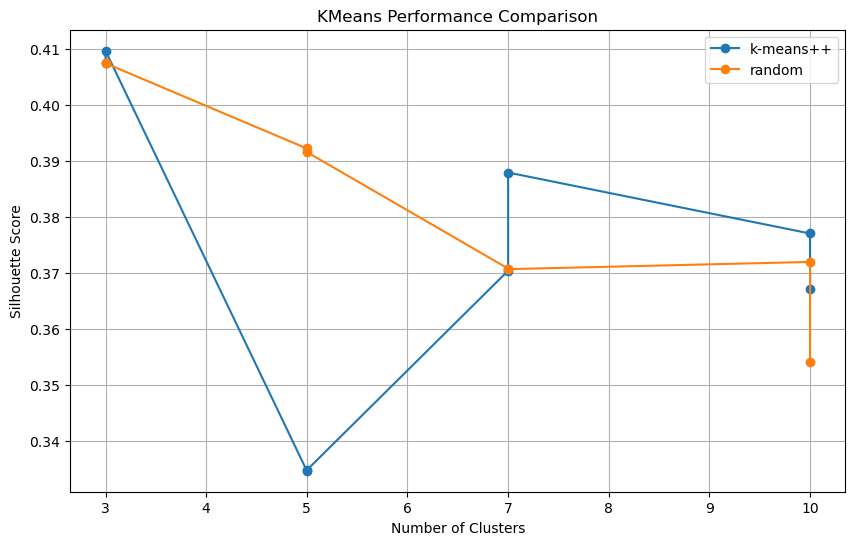

In [16]:
# 6. Visualization
plt.figure(figsize=(10, 6))
for init_method in ['k-means++', 'random']:
    subset = df_results[df_results['params'].apply(lambda x: x['init'] == init_method)]
    plt.plot(
        subset['params'].apply(lambda x: x['n_clusters']),
        subset['score'],
        marker='o',
        label=init_method
    )

plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('KMeans Performance Comparison')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
# 7. Keeping the best model
if best_model:
    best_model.save("best_kmeans_custom.joblib")
    print(f"Best model saved with score: {best_score}")

Best model saved with score: 0.4096556643956941


# Graph

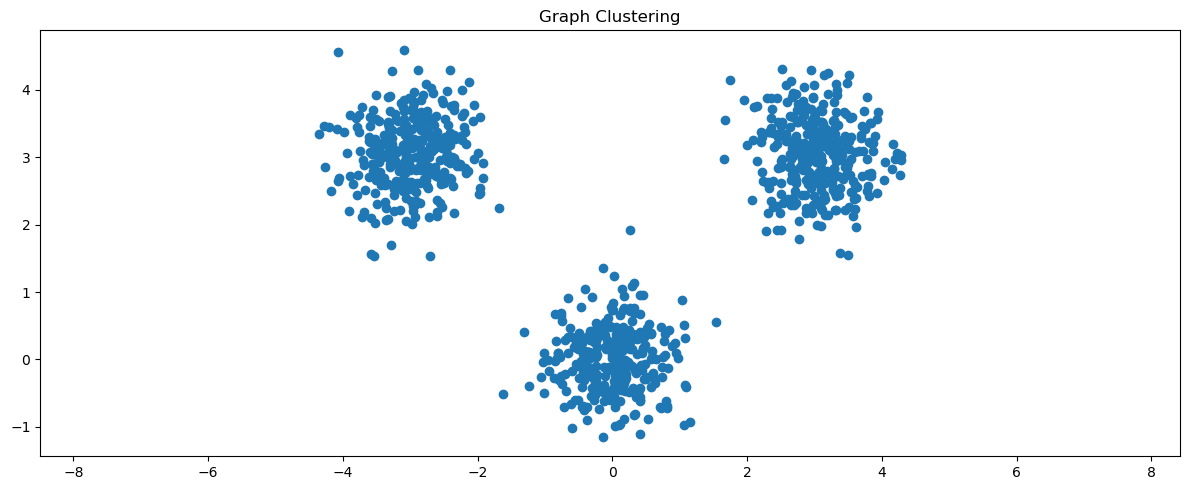

In [18]:
import numpy as np
import pandas as pd
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
np.random.seed(42)

X = np.concatenate([
    np.random.normal(loc=(0, 0), scale=0.5, size=(300, 2)),
    np.random.normal(loc=(3, 3), scale=0.5, size=(350, 2)),
    np.random.normal(loc=(-3, 3), scale=0.5, size=(350, 2))
])

dist_matrix = pairwise_distances(X)
adj_matrix = np.zeros_like(dist_matrix)
k = 5
for i in range(len(X)):
    neighbors = np.argsort(dist_matrix[i])[1:k+1]
    adj_matrix[i, neighbors] = 1


plt.figure(figsize=(12, 5))
plt.scatter(X[:, 0], X[:, 1])
plt.title('Graph Clustering')
plt.axis('equal')
plt.tight_layout()
plt.show()

In [19]:
pd.DataFrame(adj_matrix, columns=[f'x{i+1}' for i in range(1000)]).to_parquet('data_graph.parquet')

In [20]:
pd.read_parquet('data_graph.parquet').values.shape

(1000, 1000)

In [21]:
# louvain

In [22]:
def demo_pipeline(config: dict, spark=None) -> object:
    """Execute full training pipeline."""
    print(f"Available algorithms: {list(MODEL_REGISTRY.keys())}")
    print(f"\n{config.get('algorithm', 'kmeans')} parameters:")
    for param, desc in MODEL_REGISTRY[config.get('algorithm', 'kmeans')]['params_help'].items():
        print(f"  {param}: {desc}")

    model = train_pipeline(
        features_src=config['data_path'][0],
        similarity_src=config['data_path'][1],
        algorithm=config.get('algorithm', 'kmeans'),
        param_grid=config.get('params', {}),
        normalizer=config.get('preprocessing').get('normalizer'),
        sampler=config.get('preprocessing').get('sampler'),
        metric=config['metric'],
        optimizer=config.get('optimizer', 'grid'),
        spark = spark
    )
    if 'output_path' in config:
        model.save(config['output_path'])
    return model

In [23]:
base_config = {
  "data_source": "pandas",
  "optimizer":"tpe",
  "preprocessing": {
    "sampler": {
      "data_src": [
    None,
    "data_graph.parquet",
  ]
    }
  },
  "data_path": [
    None,
    "data_graph.parquet",
  ],
  "algorithm": "louvain",
  "params": {
    "resolution": [0.1, 0.3, 0.5, 0.7, 1.0, 1.5, 2.0],
    "threshold": [1e-07, 1e-06, 1e-05, 1e-04],
    "max_level": [ 5, 10, 15, 30, 45, 55]
  },
  "metric": "graph",
  "output_path": "best_louvain.joblib"
}

import json
with open('config.json', 'w') as f:
    json.dump(base_config, f, indent=2)

In [24]:
manual_model = demo_pipeline(base_config)

Available algorithms: ['kmeans', 'dbscan', 'dmon', 'louvain', 'spectral']

louvain parameters:
  resolution: Community size control (float, default=1.0)
  threshold: Merge threshold for communities (float, default=0.0000001)
  max_level: Max recursion level (int, default=15)
2025-05-16 12:09:41,475 - pattern - INFO - Loading data from data_graph.parquet


[I 2025-05-16 12:09:41,513] A new study created in memory with name: no-name-06c3ba7b-74f3-4dd3-bd89-cf6b12f99384
[I 2025-05-16 12:09:41,586] Trial 0 finished with value: 0.6226483638498206 and parameters: {'resolution': 1.142745657461917, 'threshold': 7.154741770060471e-05, 'max_level': 35}. Best is trial 0 with value: 0.6226483638498206.
[I 2025-05-16 12:09:41,664] Trial 1 finished with value: 0.6234969228114758 and parameters: {'resolution': 1.135278047694104, 'threshold': 4.242311445395658e-05, 'max_level': 37}. Best is trial 1 with value: 0.6234969228114758.
[I 2025-05-16 12:09:41,732] Trial 2 finished with value: 0.6257599683195706 and parameters: {'resolution': 0.9314157013991157, 'threshold': 8.918812277812977e-05, 'max_level': 54}. Best is trial 2 with value: 0.6257599683195706.
[I 2025-05-16 12:09:41,795] Trial 3 finished with value: 0.6178898120715322 and parameters: {'resolution': 0.8285388857689776, 'threshold': 7.919333130445819e-05, 'max_level': 31}. Best is trial 2 with

In [25]:
manual_model

In [26]:
# spectral

In [27]:
base_config = {
  "data_source": "pandas",
  "optimizer":"tpe",
  "preprocessing": {
    "sampler": {
      "data_src": [
    None,
    "data_graph.parquet",
  ]
    }
  },
  "data_path": [
    None,
    "data_graph.parquet",
  ],
  "algorithm": "spectral",
  "params": {
    "n_clusters": [2, 3, 4, 5, 6, 7],
    "n_neighbors": [3, 10 ,15],
    "assign_labels": ['kmeans', 'discretize'],
    "degree":[1]
  },
  "metric": "graph",
  "output_path": "best_spectral.joblib"
}

import json
with open('config.json', 'w') as f:
    json.dump(base_config, f, indent=2)

In [28]:
manual_model = demo_pipeline(base_config)

Available algorithms: ['kmeans', 'dbscan', 'dmon', 'louvain', 'spectral']

spectral parameters:
  n_clusters: Number of clusters (positive integer)
  n_neighbors: Neighbors for affinity matrix (int, optional)
  assign_labels: Label assignment strategy (kmeans, discretize, etc)
  degree: Degree of the polynomial kernel (int, optional)
2025-05-16 12:09:45,866 - pattern - INFO - Loading data from data_graph.parquet


[I 2025-05-16 12:09:45,907] A new study created in memory with name: no-name-12ca682e-306d-4606-affb-b457b226fb33
/opt/conda/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:310: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/opt/conda/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
[I 2025-05-16 12:09:46,214] Trial 0 finished with value: 0.5504344376559152 and parameters: {'n_clusters': 5, 'n_neighbors': 12, 'assign_labels': 'kmeans', 'degree': 1}. Best is trial 0 with value: 0.5504344376559152.
/opt/conda/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:310: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/opt/conda/lib/pytho

In [29]:
manual_model

# Attribute-Graph

In [30]:
import numpy as np
from scipy.sparse import csr_matrix

In [31]:
data = np.load('cora.npz', allow_pickle=True)

In [32]:
adj = csr_matrix((data['adj_data'], data['adj_indices'], data['adj_indptr']), shape=data['adj_shape'])
attr = csr_matrix((data['attr_data'], data['attr_indices'], data['attr_indptr']), shape=data['attr_shape'])

In [33]:
labels = data['labels']

In [34]:
pd.DataFrame(adj.todense(), columns=[f'x{i+1}' for i in range(2708)]).to_parquet('cora_graph.parquet')

In [35]:
pd.DataFrame(attr.todense(), columns=[f'x{i+1}' for i in range(1433)]).to_parquet('cora.parquet')

In [36]:
base_config = {
  "data_source": "pandas",
  "optimizer":"grid",
  "preprocessing": {},
  "data_path": [
    "cora.parquet",
    "cora_graph.parquet",
  ],
  "algorithm": "dmon",
  "params": {
    "num_clusters": [7],
    "hidden_dim": [256],
    "lambda_": [{'modularity': 1.0, 'collapse': 1.0, 'distance':0.0, 'variance': 0.0, 'entropy':0.0}],
    "epochs":[500],
    "lr":[1e-4],
    "dropout":[0.5]
  },
  "metric": "attribute-graph",
  "output_path": "best_dmon.joblib"
}

import json
with open('config.json', 'w') as f:
    json.dump(base_config, f, indent=2)

In [37]:
def demo_pipeline(config: dict, spark=None) -> object:
    """Execute full training pipeline."""
    print(f"Available algorithms: {list(MODEL_REGISTRY.keys())}")
    print(f"\n{config.get('algorithm', 'kmeans')} parameters:")
    for param, desc in MODEL_REGISTRY[config.get('algorithm', 'kmeans')]['params_help'].items():
        print(f"  {param}: {desc}")

    model = train_pipeline(
        features_src=config['data_path'][0],
        similarity_src=config['data_path'][1],
        algorithm=config.get('algorithm', 'kmeans'),
        param_grid=config.get('params', {}),
        normalizer=config.get('preprocessing').get('normalizer'),
        sampler=config.get('preprocessing').get('sampler'),
        metric=config['metric'],
        optimizer=config.get('optimizer', 'grid'),
        spark = spark
    )
    if 'output_path' in config:
        model.save(config['output_path'])
    return model

In [38]:
manual_model = demo_pipeline(base_config)

Available algorithms: ['kmeans', 'dbscan', 'dmon', 'louvain', 'spectral']

dmon parameters:
  num_clusters: Number of target clusters (positive integer)
  hidden_dim: GCN hidden dimension size (positive integer)
  lambda_: Loss coefficients dict {modularity: float, collapse: float, distance: float, variance: float, entropy: float}
  epochs: Training iterations (positive integer)
  lr: Learning rate (positive float)
  dropout: Dropout probability (0.0-1.0)
2025-05-16 12:09:58,399 - pattern - INFO - Loading data from cora.parquet
2025-05-16 12:09:58,459 - pattern - INFO - Loading data from cora_graph.parquet


/opt/conda/lib/python3.11/site-packages/optuna/samplers/_grid.py:232: UserWarning: lambda_ contains a value with the type of <class 'dict'>, which is not supported by `GridSampler`. Please make sure a value is `str`, `int`, `float`, `bool` or `None` for persistent storage.
  warnings.warn(message)
[I 2025-05-16 12:09:58,560] A new study created in memory with name: no-name-d72c08d4-448c-41c6-b47b-36d46af48cfd
/opt/conda/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {'modularity': 1.0, 'collapse': 1.0, 'distance': 0.0, 'variance': 0.0, 'entropy': 0.0} which is of type dict.
  warnings.warn(message)


Epoch 0: Loss=-0.0411
Epoch 20: Loss=-0.2543
Epoch 40: Loss=-0.3668
Epoch 60: Loss=-0.3821
Epoch 80: Loss=-0.3865
Epoch 100: Loss=-0.3883
Epoch 120: Loss=-0.3903
Epoch 140: Loss=-0.3905
Epoch 160: Loss=-0.3909
Epoch 180: Loss=-0.3910
Epoch 200: Loss=-0.3912
Epoch 220: Loss=-0.3915
Epoch 240: Loss=-0.3917
Epoch 260: Loss=-0.3921
Epoch 280: Loss=-0.3922
Epoch 300: Loss=-0.3927
Epoch 320: Loss=-0.3927
Epoch 340: Loss=-0.3928
Epoch 360: Loss=-0.3926
Epoch 380: Loss=-0.3928
Epoch 400: Loss=-0.3928
Epoch 420: Loss=-0.3926
Epoch 440: Loss=-0.3929
Epoch 460: Loss=-0.3927
Epoch 480: Loss=-0.3918


[I 2025-05-16 12:10:52,212] Trial 0 finished with value: 0.2908323085749978 and parameters: {'num_clusters': 7, 'hidden_dim': 256, 'lambda_': {'modularity': 1.0, 'collapse': 1.0, 'distance': 0.0, 'variance': 0.0, 'entropy': 0.0}, 'epochs': 500, 'lr': 0.0001, 'dropout': 0.5}. Best is trial 0 with value: 0.2908323085749978.


Epoch 0: Loss=-0.0423
Epoch 20: Loss=-0.2763
Epoch 40: Loss=-0.3774
Epoch 60: Loss=-0.3858
Epoch 80: Loss=-0.3892
Epoch 100: Loss=-0.3908
Epoch 120: Loss=-0.3909
Epoch 140: Loss=-0.3920
Epoch 160: Loss=-0.3933
Epoch 180: Loss=-0.3937
Epoch 200: Loss=-0.3939
Epoch 220: Loss=-0.3940
Epoch 240: Loss=-0.3941
Epoch 260: Loss=-0.3941
Epoch 280: Loss=-0.3942
Epoch 300: Loss=-0.3941
Epoch 320: Loss=-0.3942
Epoch 340: Loss=-0.3942
Epoch 360: Loss=-0.3942
Epoch 380: Loss=-0.3941
Epoch 400: Loss=-0.3942
Epoch 420: Loss=-0.3942
Epoch 440: Loss=-0.3941
Epoch 460: Loss=-0.3941
Epoch 480: Loss=-0.3943


In [39]:
manual_model.params

{'num_clusters': 7,
 'hidden_dim': 256,
 'lambda_': {'modularity': 1.0,
  'collapse': 1.0,
  'distance': 0.0,
  'variance': 0.0,
  'entropy': 0.0},
 'epochs': 500,
 'lr': 0.0001,
 'dropout': 0.5}

In [40]:
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, adjusted_mutual_info_score

In [41]:
nmi = normalized_mutual_info_score(labels, manual_model.labels)
ari = adjusted_rand_score(labels, manual_model.labels)
amis = adjusted_mutual_info_score(labels, manual_model.labels)
print(f"Params model: {manual_model.params}| NMI: {nmi:.4f} | ARI: {ari:.4f} | AMIS: {amis:.4f}")

Params model: {'num_clusters': 7, 'hidden_dim': 256, 'lambda_': {'modularity': 1.0, 'collapse': 1.0, 'distance': 0.0, 'variance': 0.0, 'entropy': 0.0}, 'epochs': 500, 'lr': 0.0001, 'dropout': 0.5}| NMI: 0.3122 | ARI: 0.2215 | AMIS: 0.3098
